In [1]:
!wget -qq https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!wget -qq https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
!wget https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv

--2025-09-22 11:42:14--  https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 999 [text/plain]
Saving to: ‘signnames.csv’

signnames.csv       100%[===================>]     999  --.-KB/s    in 0s      

2025-09-22 11:42:14 (76.3 MB/s) - ‘signnames.csv’ saved [999/999]



In [75]:
!wget -qq https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip
unzip -q GTSRB_Final_Test_GT.zip -d /kaggle/working/

In [77]:

import zipfile

In [11]:
extract_dir = '/kaggle/working/'
with zipfile.ZipFile('/kaggle/working/GTSRB_Final_Test_Images.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [14]:
with zipfile.ZipFile('/kaggle/working/GTSRB_Final_Training_Images.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [80]:
with zipfile.ZipFile('/kaggle/working/GTSRB_Final_Test_GT.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [1]:
import cv2
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms as T, models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
from torch_snippets import *
%matplotlib inline

In [2]:
df = pd.read_csv('/kaggle/working/signnames.csv')
df.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [3]:
df.set_index('ClassId',inplace=True)
class_ids = df.to_dict()['SignName']
class_ids = {f'{k:05d}': v for k,v in class_ids.items()}
id2int = {v: i for i, (k,v) in enumerate(class_ids.items())}

In [22]:
train_files = glob.glob('/kaggle/working/Train/Final_Training/Images/*/*.ppm')
np.random.seed(10)
np.random.shuffle(train_files)
len(train_files)

39209

In [23]:
test_files  = glob.glob('/kaggle/working/Test/Final_Test/Images/*.ppm')
np.random.shuffle(test_files)
len(test_files)

12630

In [24]:
train_files, val_files = train_test_split(train_files,test_size=0.2,random_state=1)
len(train_files),len(val_files)

(31367, 7842)

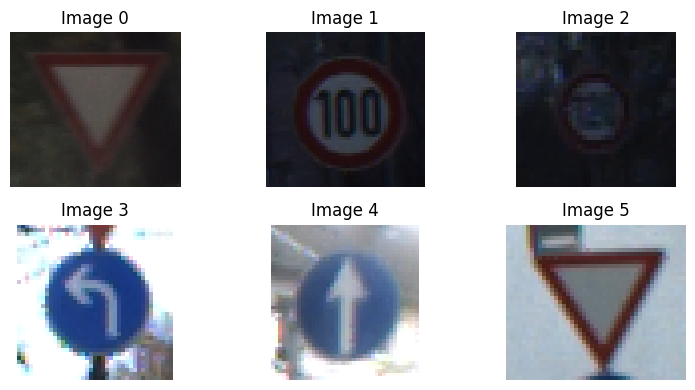

In [25]:
fig, axes = plt.subplots(2, 3, figsize=(8, 4))

for i, file in enumerate(train_files[:6]):
    img = cv2.imread(file)              # BGR image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    
    ax = axes[i // 3, i % 3]           # Select subplot
    ax.imshow(img)
    ax.set_title(f"Image {i}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [47]:
trn_tf = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ColorJitter(brightness=(0.8,1.2),contrast=(0.8,1.2),saturation=(0.8,1.2),hue=0.25),
    T.RandomAffine(5, translate = (0.01,0.1)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_tf = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [83]:
class RoadSignDataset(Dataset):
    def __init__(self,data,transform):
        self.data = data
        self.transform = transform
        logger.info(len(self.data))
    def __len__(self):
        return len(self.data)
    def __getitem__(self,ix):
        
        f = self.data[ix]
        clss = f.split('/')[-2]
        img = cv2.imread(f)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img, class_ids[clss]
        
    def choose(self):
        return self[randint(len(self))]
        
    def collate_fn(self,batch):
        _imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img) for img in _imgs]
        imgs = torch.stack(imgs).to(device)
        classes = torch.tensor([id2int[c] for c in classes]).to(device)
        return imgs,classes,

In [49]:
train_set = RoadSignDataset(train_files,transform = trn_tf)
val_set = RoadSignDataset(val_files,transform = val_tf)
test_set = RoadSignDataset(test_files,transform = val_tf)

[09/22/25 12:56:07] INFO     31367                                                                                                                  ]8;id=173369;file:///tmp/ipykernel_183/1823247237.py:5\1823247237.py]8;;\:]8;id=893635;file:///tmp/ipykernel_183/1823247237.py:5#__init__:5\__init__:5]8;;\

                    INFO     7842                                                                                                                   ]8;id=901602;file:///tmp/ipykernel_183/1823247237.py:5\1823247237.py]8;;\:]8;id=12459;file:///tmp/ipykernel_183/1823247237.py:5#__init__:5\__init__:5]8;;\

                    INFO     12630                                                                                                                  ]8;id=241081;file:///tmp/ipykernel_183/1823247237.py:5\1823247237.py]8;;\:]8;id=436188;file:///tmp/ipykernel_183/1823247237.py:5#__init__:5\__init__:5]8;;\

In [73]:
train_loader = DataLoader(train_set,batch_size=64,collate_fn = train_set.collate_fn)
val_loader = DataLoader(val_set,batch_size=64,collate_fn = val_set.collate_fn)
test_loader = DataLoader(test_set,batch_size=64,shuffle=False,collate_fn = test_set.collate_fn)

In [51]:
def conv_func(in_channels,out_channels):
   return nn.Sequential( 
       nn.Dropout(0.2),
       nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
       nn.ReLU(),
       nn.BatchNorm2d(out_channels),
       nn.MaxPool2d(2),

   )

In [52]:
class RoadSignClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            conv_func(3,64),
            conv_func(64,64),
            conv_func(64,128),
            conv_func(128,256),
            nn.Flatten(),
            nn.Linear(256*2*2,256),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(256,len(id2int))            
        )
        self.loss_fn = nn.CrossEntropyLoss()
    def forward(self,x):
        return self.model(x)
    def compute_metrics(self,preds,labels):
        loss = self.loss_fn(preds,labels)
        acc = (torch.max(preds,1)[1] == labels).float().mean()
        return loss, acc

In [53]:
def train_batch(model,data,optimizer,criterion):
    model.train()
    imgs,labels = data
    preds = model(imgs)
    optimizer.zero_grad()
    loss,acc = criterion(preds,labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

In [54]:
@torch.no_grad()
def validate_batch(model,data,criterion):
    model.eval()
    imgs,labels = data
    preds = model(imgs)
    loss,acc = criterion(preds,labels)
    return loss.item(), acc.item()

In [55]:
model = RoadSignClassifierModel()
model = model.to(device)
criterion = model.compute_metrics
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
n_epochs = 50
log = Report(n_epochs)

In [63]:
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

for i in range(n_epochs):
    N = len(train_loader)
    trn_losses, trn_accs = [], []
    val_losses, val_accs = [], []
    
    for j, data in enumerate(train_loader):
        loss, acc = train_batch(model, data, optimizer, criterion)
        trn_losses.append(loss)
        trn_accs.append(acc)
        log.record(i+(j+1)/N, trn_loss=loss, trn_acc=acc, end='\r')
    
    for j, data in enumerate(val_loader):
        loss, acc = validate_batch(model, data, criterion)
        val_losses.append(loss)
        val_accs.append(acc)
        log.record(i+(j+1)/N, val_loss=loss, val_acc=acc, end='\r')
    
    history["train_loss"].append(sum(trn_losses)/len(trn_losses))
    history["train_acc"].append(sum(trn_accs)/len(trn_accs))
    history["val_loss"].append(sum(val_losses)/len(val_losses))
    history["val_acc"].append(sum(val_accs)/len(val_accs))
    
    log.report_avgs(i+1)

EPOCH: 1.000  val_acc: 0.834  val_loss: 0.600  trn_loss: 1.002  trn_acc: 0.707  (2115.83s - 103675.58s remaining)
EPOCH: 2.000  val_acc: 0.842  val_loss: 0.658  trn_loss: 0.384  trn_acc: 0.875  (2150.56s - 51613.33s remaining)
EPOCH: 3.000  val_acc: 0.900  val_loss: 0.376  trn_loss: 0.271  trn_acc: 0.913  (2185.04s - 34232.30s remaining)
EPOCH: 4.000  val_acc: 0.910  val_loss: 0.408  trn_loss: 0.220  trn_acc: 0.928  (2219.89s - 25528.68s remaining)
EPOCH: 5.000  val_acc: 0.894  val_loss: 0.497  trn_loss: 0.193  trn_acc: 0.937  (2254.58s - 20291.21s remaining)
EPOCH: 6.000  val_acc: 0.921  val_loss: 0.357  trn_loss: 0.173  trn_acc: 0.943  (2289.25s - 16787.83s remaining)
EPOCH: 7.000  val_acc: 0.911  val_loss: 0.403  trn_loss: 0.153  trn_acc: 0.949  (2323.87s - 14275.18s remaining)
EPOCH: 8.000  val_acc: 0.920  val_loss: 0.422  trn_loss: 0.149  trn_acc: 0.951  (2358.65s - 12382.93s remaining)
EPOCH: 9.000  val_acc: 0.911  val_loss: 0.416  trn_loss: 0.138  trn_acc: 0.954  (2393.40s - 109

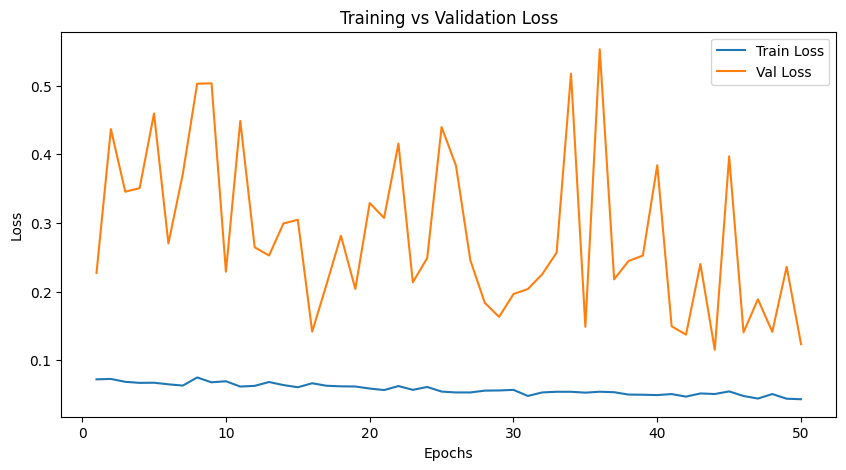

In [64]:
epochs = range(1, n_epochs+1)

# Loss plot
plt.figure(figsize=(10,5))
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


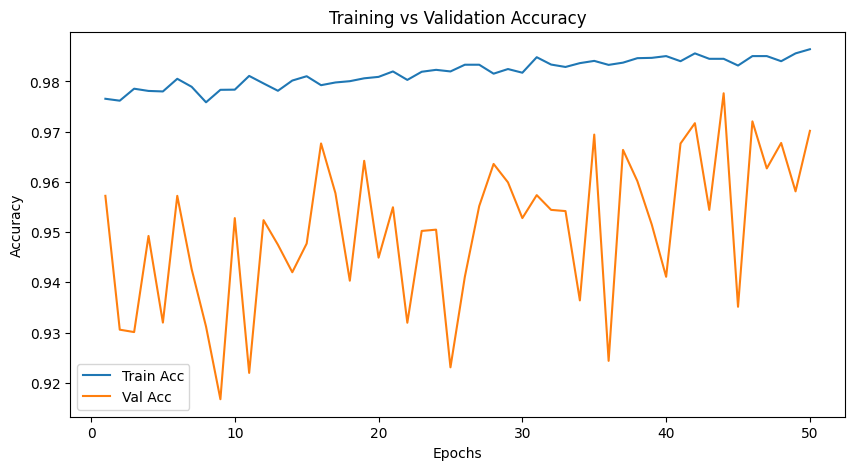

In [65]:
# Accuracy plot
plt.figure(figsize=(10,5))
plt.plot(epochs, history["train_acc"], label="Train Acc")
plt.plot(epochs, history["val_acc"], label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

In [82]:
pd.read_csv('/kaggle/working/GT-final_test.csv',sep=';')

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,00000.ppm,53,54,6,5,48,49,16
1,00001.ppm,42,45,5,5,36,40,1
2,00002.ppm,48,52,6,6,43,47,38
3,00003.ppm,27,29,5,5,22,24,33
4,00004.ppm,60,57,5,5,55,52,11
...,...,...,...,...,...,...,...,...
12625,12625.ppm,42,41,5,6,37,36,12
12626,12626.ppm,50,51,6,5,45,46,33
12627,12627.ppm,29,29,6,6,24,24,6
12628,12628.ppm,48,49,5,6,43,44,7


In [86]:
test_set = RoadSignDataset(test_files,transform = val_tf,phase= 'test')

[09/22/25 14:41:27] INFO     12630                                                                                                                  ]8;id=308051;file:///tmp/ipykernel_183/2369666460.py:6\2369666460.py]8;;\:]8;id=219944;file:///tmp/ipykernel_183/2369666460.py:6#__init__:6\__init__:6]8;;\

In [87]:
test_loader = DataLoader(test_set,batch_size=64,shuffle=False,collate_fn = test_set.collate_fn)

In [91]:
test_files[:10]

['/kaggle/working/Test/Final_Test/Images/07564.ppm',
 '/kaggle/working/Test/Final_Test/Images/08557.ppm',
 '/kaggle/working/Test/Final_Test/Images/05038.ppm',
 '/kaggle/working/Test/Final_Test/Images/11294.ppm',
 '/kaggle/working/Test/Final_Test/Images/02090.ppm',
 '/kaggle/working/Test/Final_Test/Images/04457.ppm',
 '/kaggle/working/Test/Final_Test/Images/07991.ppm',
 '/kaggle/working/Test/Final_Test/Images/06387.ppm',
 '/kaggle/working/Test/Final_Test/Images/07598.ppm',
 '/kaggle/working/Test/Final_Test/Images/03345.ppm']

Predicted Class: 4


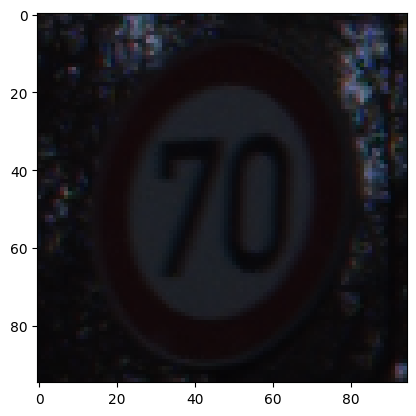

In [98]:
img = read('/kaggle/working/Test/Final_Test/Images/07564.ppm',1)
plt.imshow(img)
img = val_tf(img).unsqueeze(0).to(device)
with torch.no_grad():
    output = model(img)
    pred_class = torch.argmax(output, dim=1).item()

print("Predicted Class:", pred_class)

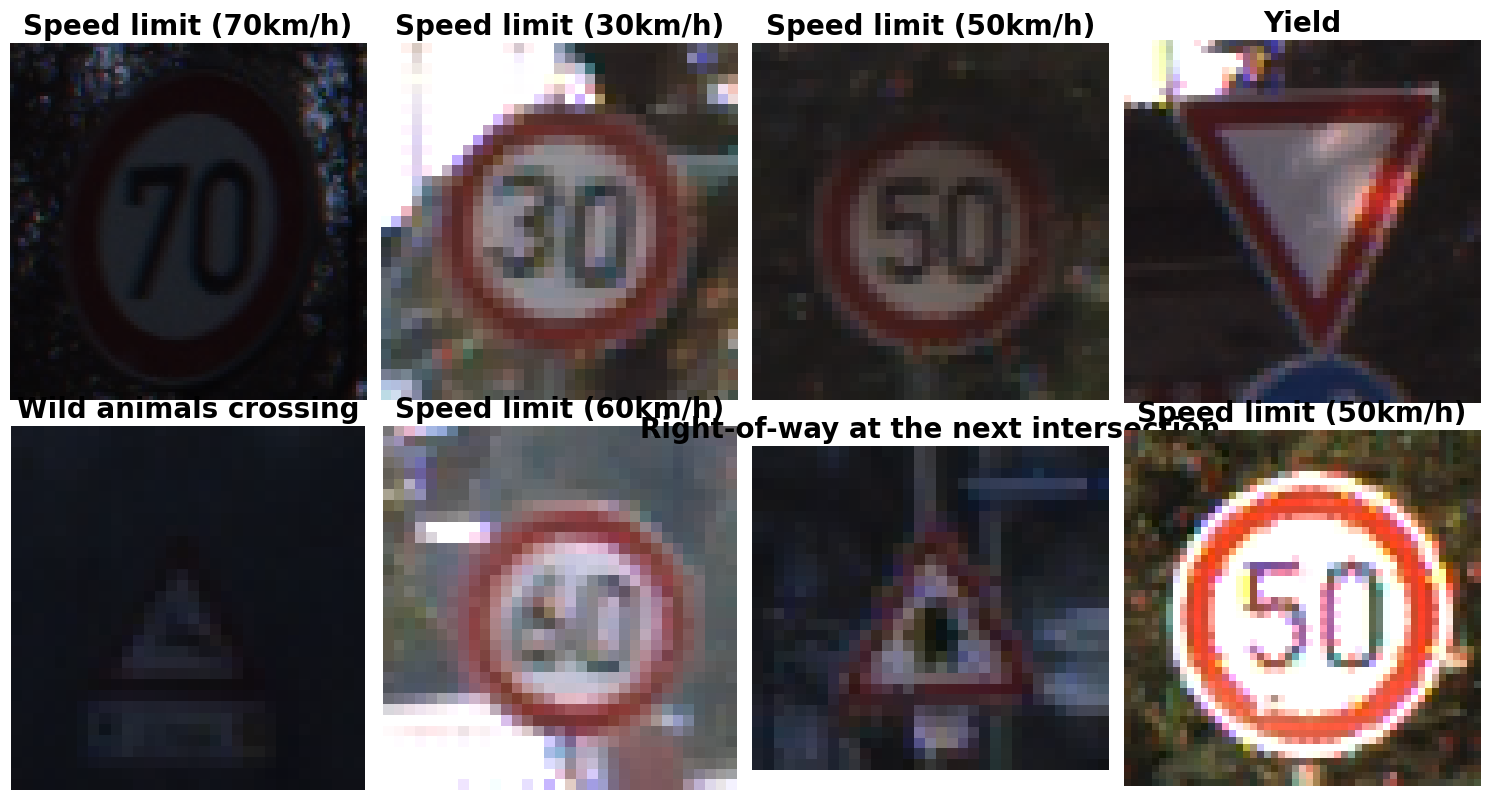

In [102]:
int2id = {v: k for k, v in id2int.items()}

def show_predictions(model, files, n=6):
    plt.figure(figsize=(15, 8))
    model.eval()
    
    for i, file in enumerate(files[:n]):
        # Read & preprocess
        img = read(file, 1)
        img_input = val_tf(img).unsqueeze(0).to(device)

        # Predict
        with torch.no_grad():
            output = model(img_input)
            pred_class = torch.argmax(output, dim=1).item()
        
        # Plot
        plt.subplot(2, n//2, i+1)
        plt.imshow(img)
        plt.title(int2id[pred_class], fontsize=20, fontweight='bold')
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Show predictions for 8 test images
show_predictions(model, test_files[:10], n=8)


In [103]:
torch.save(model.state_dict(),'traffic_sign_model.pth')

In [110]:
from huggingface_hub import HfApi, create_repo, login , upload_file

In [105]:
login()

In [106]:
api = HfApi()

In [107]:
repo_url = api.create_repo(repo_id='TrafficSignNet',repo_type='space',space_sdk='gradio')
print(repo_url)

https://huggingface.co/spaces/faranbutt789/TrafficSignNet


In [111]:
repo_id = "faranbutt789/TrafficSignNet"
upload_file(
    path_or_fileobj = '/kaggle/working/traffic_sign_model.pth',
    path_in_repo = 'traffic_sign_model.pth',
    repo_id=repo_id,
    repo_type="space"
)

Uploading...:   0%|          | 0.00/2.74M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/spaces/faranbutt789/TrafficSignNet/commit/e617babf166e673a1e2dbaeecd45988b26008def', commit_message='Upload traffic_sign_model.pth with huggingface_hub', commit_description='', oid='e617babf166e673a1e2dbaeecd45988b26008def', pr_url=None, repo_url=RepoUrl('https://huggingface.co/spaces/faranbutt789/TrafficSignNet', endpoint='https://huggingface.co', repo_type='space', repo_id='faranbutt789/TrafficSignNet'), pr_revision=None, pr_num=None)